## Libraries

In [1]:
import torch, time, pandas, numpy, PIL        
import torch.nn as nn, torch.nn.functional as F, matplotlib.pyplot as plt
from torch.autograd import Variable

## Scour at bridge pillars

--2023-05-05 07:36:42--  https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11831-018-09304-w/MediaObjects/11831_2018_9304_Fig2_HTML.jpg?as=webp
Resolving media.springernature.com (media.springernature.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to media.springernature.com (media.springernature.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72576 (71K) [image/webp]
Saving to: ‘11831_2018_9304_Fig2_HTML.jpg?as=webp’

11831_2018_9304_Fig 100%[===================>]  70.88K  --.-KB/s    in 0.01s   

2023-05-05 07:36:42 (4.76 MB/s) - ‘11831_2018_9304_Fig2_HTML.jpg?as=webp’ saved [72576/72576]



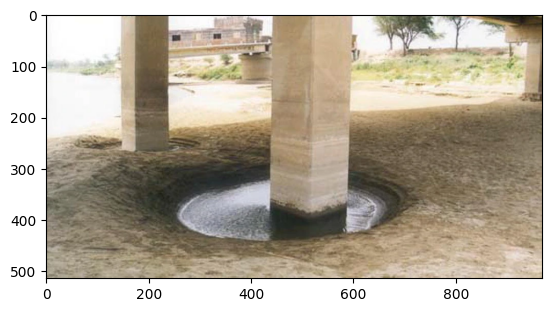

In [2]:
!wget "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11831-018-09304-w/MediaObjects/11831_2018_9304_Fig2_HTML.jpg?as=webp"
im = PIL.Image.open("/kaggle/working/11831_2018_9304_Fig2_HTML.jpg?as=webp")
plt.imshow(im)

## Sonar, Stage and Discharge readings.

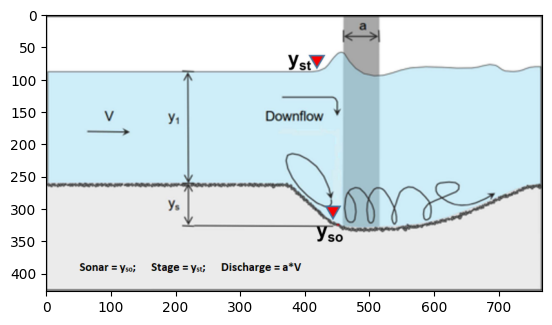

In [3]:
im = PIL.Image.open("/kaggle/input/ssdum/Sonar_Stage_Discharge.png")
plt.imshow(im)

## Load Data

In [4]:
train_csv_path = '/kaggle/input/ssdum/SSD-UM.xlsx'
train_df = pandas.read_excel(train_csv_path)
train_df.head()

,T,So,St,Ds
0,2009-05-01 00:00:00,29.704943,36.363720,2350.102041
1,2009-05-01 01:00:00,29.704922,36.367115,2361.989796
2,2009-05-01 02:00:00,29.704878,36.370681,2373.877551
3,2009-05-01 03:00:00,29.704809,36.374422,2385.765306
4,2009-05-01 04:00:00,29.704717,36.378341,2397.602041


## Convert and Arrange Data

In [5]:
data_len = len(train_df)

sonar = numpy.zeros(data_len)
stage = numpy.zeros(data_len)
discharge = numpy.zeros(data_len)
#SSSD = numpy.zeros((4,data_len)) # [Season Sonar Stage Discharge]
season = numpy.zeros(data_len)
iter_index = 0

for row in train_df.iloc:
    time_string = str(row[0])
    #print('Total:',time_string[0:16],'Month:',time_string[5:7],'Day:',time_string[8:10],'Hour:',time_string[11:13])
    
    season_temp = (float(time_string[5:7])  +  (float(time_string[8:10])   + float(time_string[11:13])/24 ) /30  )/12
    # season = (Month +  (Day + Hour/24)/30   )/12
    
    sonar[iter_index] = (row[1]).astype(float)
    stage[iter_index] = (row[2]).astype(float)
    discharge[iter_index] = (row[3]).astype(float)
    season[iter_index] = season_temp
    
    #SSSD[:,iter_index] = [season_temp, sonar[iter_index], stage[iter_index], discharge[iter_index]]
    iter_index = iter_index + 1
    
print(sonar.shape)

(3673,)


## Plotting

[1.14155251e-04 2.28310502e-04 3.42465753e-04 ... 4.19063927e-01
 4.19178082e-01 4.19292237e-01]


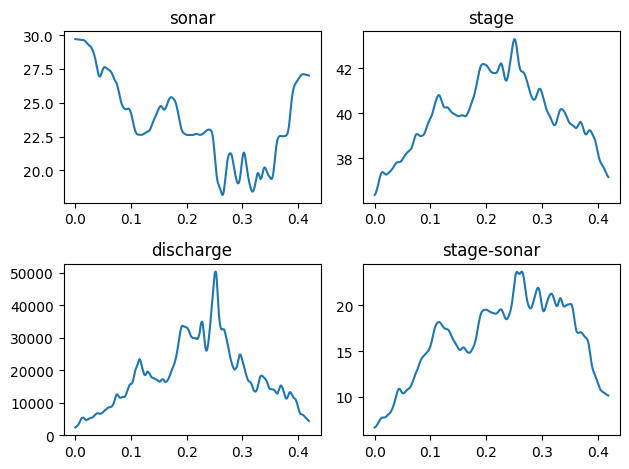

In [6]:
x_axis = numpy.linspace(1,data_len, num=data_len)/24/365 #Time in year

print(x_axis)
plt.figure(1)
plt.subplot(2,2,1)
plt.plot(x_axis,sonar)
plt.gca().set_title('sonar')
plt.subplot(2,2,2)
plt.plot(x_axis,stage)
plt.gca().set_title('stage')
plt.subplot(2,2,3)
plt.plot(x_axis,discharge)
plt.gca().set_title('discharge')
plt.subplot(2,2,4)
plt.plot(x_axis,stage-sonar)
plt.gca().set_title('stage-sonar')
plt.tight_layout()

## Scour

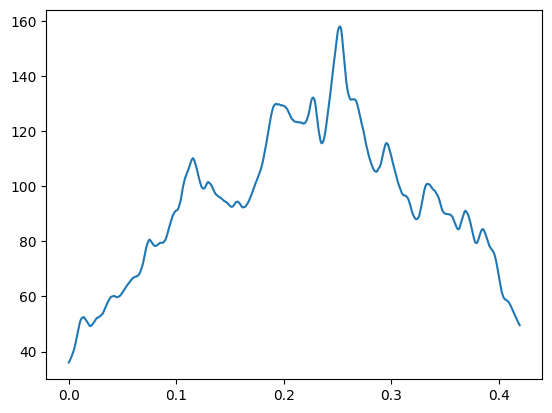

In [7]:
scour = ((stage-sonar)**0.13) * (discharge**0.43)
plt.plot(x_axis,scour)

## Data Adjustment 

### for 2-days ahead prediction 
2-days = 48 samples

### Input considerations

Season[t] Sonar[t] Stage[t] Discharge[t] Scour[t] Sonar[t-1] Stage[t-1] Discharge[t-1] Scour[t-1] Scour[t-12] Scour[t-24] Scour[t-36] Scour[t-48]

### Output
Scour[t + 48]

In [8]:
Input_ = numpy.zeros((data_len-96,13))
Output_=numpy.zeros(data_len-96)

index_last = data_len-48

for iter_index in range(48,index_last):
    
    Input_[iter_index-48,:] = [season[iter_index], sonar[iter_index], stage[iter_index], discharge[iter_index], scour[iter_index], \
              sonar[iter_index-1], stage[iter_index-1], discharge[iter_index-1], scour[iter_index-1], \
             scour[iter_index-12], scour[iter_index-24], scour[iter_index-36], scour[iter_index-48]]
    Output_[iter_index-48] = scour[iter_index+48]
    
print(Input_.shape, Output_.shape, iter_index-48)

(3577, 13) (3577,) 3576


In [9]:
data_len2 = len(Output_)
hr_in_4wk = 24*7*4
I_test = Input_[-hr_in_4wk-1:-1,:]
O_test = Output_[-hr_in_4wk-1:-1]

print(I_test.shape, O_test.shape, len(Output_))

Input_ = Input_[0:data_len2-hr_in_4wk,:]
Output_ = Output_[0:data_len2-hr_in_4wk]
print(Output_.shape, Input_.shape)

(672, 13) (672,) 3577
(2905,) (2905, 13)


## Normalization

In [10]:
x = torch.tensor(Input_).float()  
y = torch.tensor(Output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)

i_val = torch.tensor(I_test).float()  
o_val = torch.tensor(O_test).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)

max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print('\n Ranges:',range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

tensor(158.0236) tensor(49.2382) tensor([7.5544e-01, 2.9684e+01, 4.3291e+01, 5.0296e+04, 1.5802e+02, 2.9684e+01,
        4.3291e+01, 5.0296e+04, 1.5802e+02, 1.5802e+02, 1.5802e+02, 1.5802e+02,
        1.5802e+02]) tensor([4.2500e-01, 1.8173e+01, 3.6738e+01, 3.2245e+03, 4.1586e+01, 1.8173e+01,
        3.6727e+01, 3.1953e+03, 4.1414e+01, 3.9793e+01, 3.8318e+01, 3.7072e+01,
        3.6025e+01])

 Ranges: tensor([3.3044e-01, 1.1511e+01, 6.5530e+00, 4.7071e+04, 1.1644e+02, 1.1511e+01,
        6.5644e+00, 4.7101e+04, 1.1661e+02, 1.1823e+02, 1.1971e+02, 1.2095e+02,
        1.2200e+02]) tensor(108.7855)


## Point Prediction LSTM Model

We wrote this LSTM network code according to the following script:

https://www.kaggle.com/code/drvaibhavkumar/lstm-for-time-series-prediction-in-pytorch/notebook

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


input_dim = len(range_x)    # input dimension
hidden_dim = 100  # hidden layer dimension
output_dim = 1   # output dimension

net = LSTM(input_size = input_dim, hidden_layer_size = hidden_dim, output_size = output_dim)


print(net)  # net architecture

LSTM(
  (lstm): LSTM(13, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [12]:
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)

minimum_train_loss = 1e5 #High initial values
minimum_val_loss = 1e5

y_pred_all=torch.zeros(len(y))

for iter_index in range(len(y)):
    optimizer.zero_grad()
    net.hidden_cell = (torch.zeros(1, 1, net.hidden_layer_size),
                    torch.zeros(1, 1, net.hidden_layer_size))
    
    x_local = x[iter_index,:]
    x_local = x_local.view((1,len(range_x)))
    y_pred = net(x_local)
    y_pred_all[iter_index] = y_pred

    single_loss = loss_func(y_pred, y[iter_index])    
    
    single_loss.backward()
    optimizer.step()

    if iter_index%400 == 399:        
        print ("Iter [{}/{}], Loss: {:.9f}  " \
               .format(iter_index+1, len(y), single_loss))

Iter [400/2905], Loss: 0.000000362  
Iter [800/2905], Loss: 0.000000021  
Iter [1200/2905], Loss: 0.000000025  
Iter [1600/2905], Loss: 0.000000009  
Iter [2000/2905], Loss: 0.000000199  
Iter [2400/2905], Loss: 0.000000009  
Iter [2800/2905], Loss: 0.000000011  


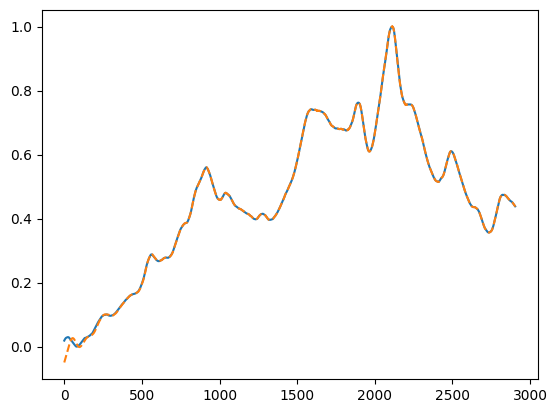

In [13]:
plt.plot(y)
plt.plot(y_pred_all.detach().numpy(),'--')

In [14]:
y_pred_val =torch.zeros(len(o_val))

for iter_index in range(len(o_val)):
    x_local = i_val[iter_index,:]
    x_local = x_local.view((1,len(range_x)))
    y_pred_val[iter_index] = net(x_local)

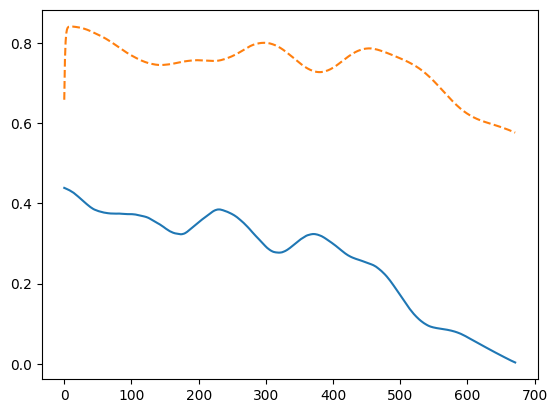

In [15]:
plt.plot(o_val)
plt.plot(y_pred_val.detach().numpy(),'--')

## Point Prediction RNN Model

Digit Classification RNN:

https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch

In [16]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = state_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, state_dim, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, self.hidden_dim))
        out, hn = self.rnn(x, h0)
        out = self.fc(out) 
        return out

input_dim = len(range_x)    # input dimension
hidden_dim = 100  # hidden layer dimension
output_dim = 1   # output dimension
state_dim = 100

net = RNNModel(input_dim = input_dim, hidden_dim = hidden_dim, state_dim=state_dim, output_dim = output_dim)

print(net)  # net architecture

RNNModel(
  (rnn): RNN(13, 100, num_layers=100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [17]:
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)

minimum_train_loss = 1e5 #High initial values
minimum_val_loss = 1e5

y_pred_all=torch.zeros(len(y))

for iter_index in range(len(y)):
    
    optimizer.zero_grad()    
    x_local = x[iter_index,:]
    x_local = x_local.view((1,len(range_x)))
    y_pred = net(x_local)
    y_pred_all[iter_index] = y_pred

    single_loss = loss_func(y_pred, y[iter_index])
    
    single_loss.backward()
    optimizer.step()

    if iter_index%200 == 199:        
        print ("Iter [{}/{}], Loss: {:.9f}  " \
               .format(iter_index+1, len(y), single_loss))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iter [200/2905], Loss: 0.000000024  
Iter [400/2905], Loss: 0.000000025  
Iter [600/2905], Loss: 0.000000004  
Iter [800/2905], Loss: 0.000001262  
Iter [1000/2905], Loss: 0.000000025  
Iter [1200/2905], Loss: 0.000000080  
Iter [1400/2905], Loss: 0.000000040  
Iter [1600/2905], Loss: 0.000000005  
Iter [1800/2905], Loss: 0.000000039  
Iter [2000/2905], Loss: 0.000000001  
Iter [2200/2905], Loss: 0.000000020  
Iter [2400/2905], Loss: 0.000000007  
Iter [2600/2905], Loss: 0.000000036  
Iter [2800/2905], Loss: 0.000000008  


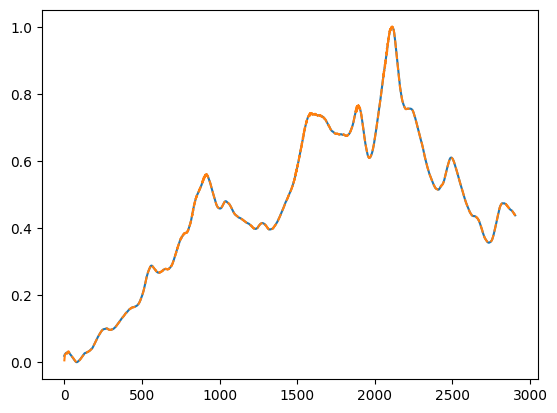

In [18]:
plt.plot(y)
plt.plot(y_pred_all.detach().numpy(),'--')

In [19]:
y_pred_val =torch.zeros(len(o_val))

for iter_index in range(len(o_val)):
    x_local = i_val[iter_index,:]
    x_local = x_local.view((1,len(range_x)))
    y_pred_val[iter_index] = net(x_local)

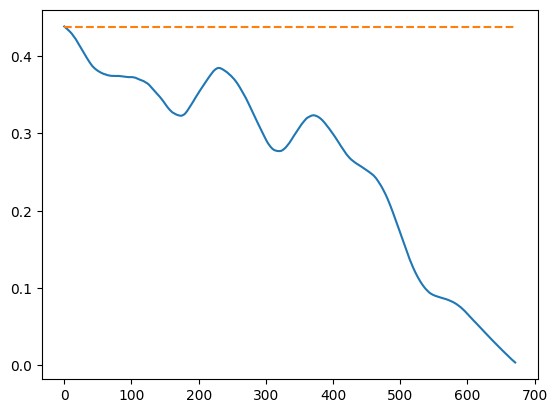

In [20]:
plt.plot(o_val)
plt.plot(y_pred_val.detach().numpy(),'--')